In [1]:
import os

In [2]:
os.environ["OMP_NUM_THREADS"] = "1" 

In [3]:
os.environ["OMP_NUM_THREADS"] 

'1'

In [4]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

In [5]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')

# Iris Classification

In [6]:
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [7]:
X_iris = iris.drop('species', axis=1)
X_iris.shape

(150, 4)

In [8]:
y_iris = iris['species']
y_iris.shape

(150,)

In [9]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_iris, y_iris, random_state=1)

In [10]:
from sklearn.naive_bayes import GaussianNB 
model = GaussianNB()

In [11]:
model.fit(Xtrain, ytrain)

GaussianNB()

In [12]:
y_model = model.predict(Xtest) 

# Model Evaluation

## Using Validation Set

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.9736842105263158

One disadvantage of using a holdout set for model validation is that we have lost a
portion of our data to the model training. In the preceding case, 25% of the dataset is used for the test dataset and does not contribute to the training of the model! 

This is not optimal, especially if the initial set of training data is small. So we use Cross Validation.

## Using Cross Validation

Repeating the validation across different subsets of the data gives us an even better
idea of the performance of the algorithm.

### 5-Fold CV

In [14]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_iris, y_iris, cv=5)

In [15]:
scores

array([0.93333333, 0.96666667, 0.93333333, 0.93333333, 1.        ])

In [16]:
scores.mean()

np.float64(0.9533333333333334)

### Leave-one-out CV

In [17]:
from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model, X_iris, y_iris, cv=LeaveOneOut())
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Because we have 150 samples, the leave-one-out cross-validation yields scores for 150 trials, and each score indicates either a successful (1.0) or an unsuccessful (0.0) prediction. Taking the mean of these gives an estimate of the error rate,

In [18]:
scores.mean()

np.float64(0.9533333333333334)

# Model Selection

In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

In [20]:
def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

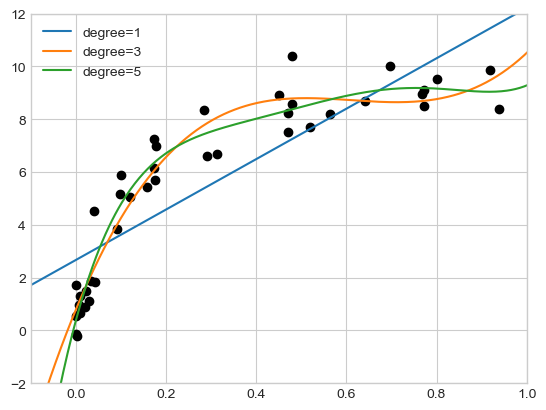

In [21]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]
plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()

for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))

plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

The knob controlling model complexity in this case is the degree of the polynomial,
which can be any nonnegative integer. A useful question to answer is this: what
degree of polynomial provides a suitable trade-off between bias (underfitting) and
variance (overfitting)?

## Validation Curve

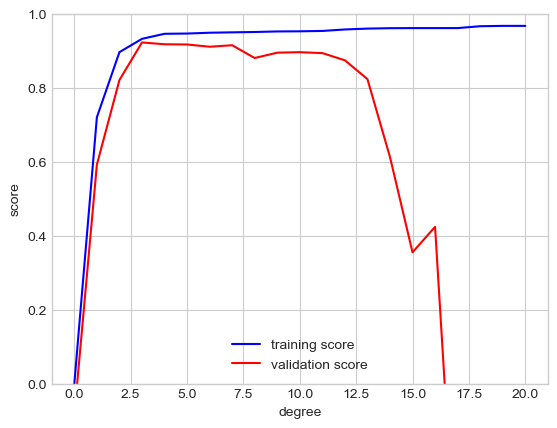

In [27]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_scores, val_scores = validation_curve(PolynomialRegression(), X, y, 
                                          param_name='polynomialfeatures__degree',
                                          param_range=degree, cv=7)

plt.plot(degree, np.median(train_scores, 1),
         color='blue', label='training score')

plt.plot(degree, np.median(val_scores, 1),
         color='red', label='validation score')

plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

This shows precisely the qualitative behavior we expect: the training score is every‐
where higher than the validation score, the training score is monotonically improving
with increased model complexity, and the validation score reaches a maximum before
dropping off as the model becomes overfit.

From the validation curve, we can determine that the optimal trade-off between bias
and variance is found for a third-order polynomial. We can compute and display this
fit over the original data as follows,

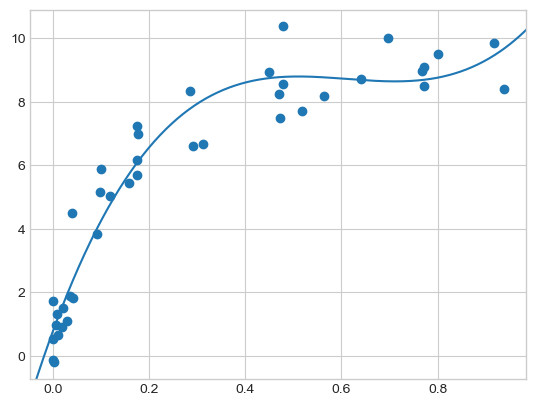

In [28]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test)
plt.axis(lim)

## Validation in Practice: Grid Search

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'polynomialfeatures__degree': np.arange(21),
    'linearregression__fit_intercept': [True, False]
}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

In [30]:
grid.fit(X, y);

In [31]:
grid.best_params_

{'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 4}

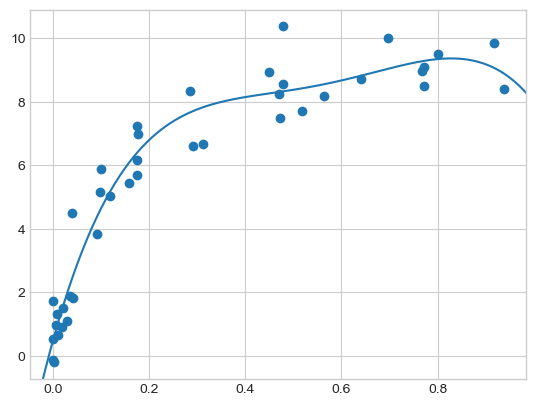

In [32]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()

y_test = model.fit(X, y).predict(X_test)

plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

# Feature Engineering

## One-hot encoding

In [33]:
data = [
 {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
 {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
 {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
 {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

In [34]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]])

In [35]:
vec.get_feature_names_out()

array(['neighborhood=Fremont', 'neighborhood=Queen Anne',
       'neighborhood=Wallingford', 'price', 'rooms'], dtype=object)

In [36]:
vec = DictVectorizer(sparse=True, dtype=int) # try sparse
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int32'>'
	with 12 stored elements in Compressed Sparse Row format>

## Derived Features

### Polynomial Features

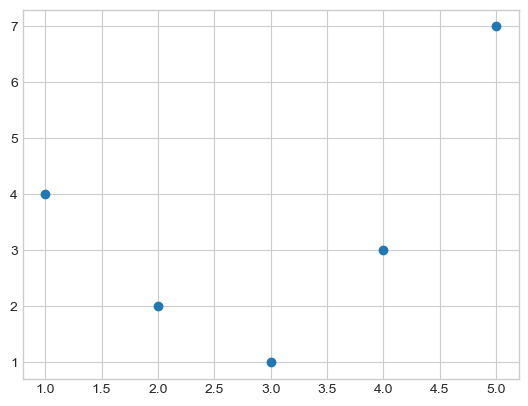

In [37]:
x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y);

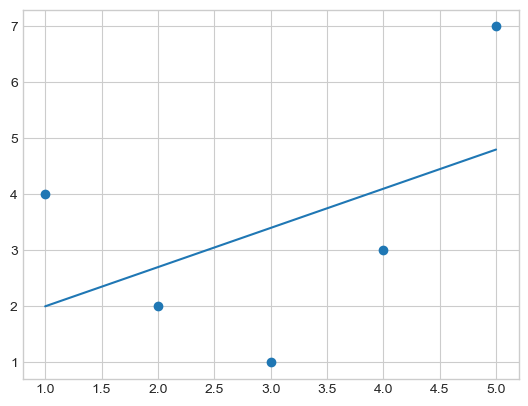

In [38]:
from sklearn.linear_model import LinearRegression
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit);

In [39]:
x

array([1, 2, 3, 4, 5])

In [41]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
X2

array([[  1.,   1.,   1.],
       [  2.,   4.,   8.],
       [  3.,   9.,  27.],
       [  4.,  16.,  64.],
       [  5.,  25., 125.]])

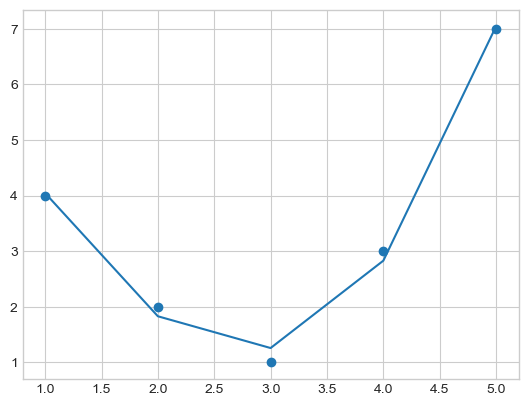

In [42]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit);